In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [201]:
class Value:
    def __init__(self, data, _children=(), _op='', label= ' '):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #leaf node backward does nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
            
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other):
        return self + other
        

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/ (math.exp(2*x) +1 )
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
      



In [202]:
from graphviz import Digraph

def trace(root):
    """
    Builds a set of all nodes (Value objects) and edges (dependencies) in a graph
    starting from the root Value object.
    """
    nodes = set()
    edges = set()

    def build(v):
        # If the node hasn't been visited, add it
        if v not in nodes:
            nodes.add(v)
            # Recursively build for its children (previous nodes in the computation)
            for child in v._prev:
                edges.add((child, v)) # Add an edge from child to current node
                build(child) # Recurse on the child

    build(root) # Start the recursive build from the root
    return nodes, edges


def draw_dot(root):
    """
    Generates a Graphviz Digraph object from the traced graph,
    representing the computational flow.
    """
    nodes, edges = trace(root) # Get all nodes and edges from the computational graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right layout

    # Create nodes for each Value object
    for n in nodes:
        # Generate a unique ID for the node (using its memory address)
        uid = str(id(n))
        
        # Create a rectangular ('record') node for the Value object itself
        # Label shows data and its unique ID (for debugging/identification)
        # Also show the gradient if it exists
        dot.node(name=uid, label="{ %s|data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        # If this Value object is a result of an operation (i.e., it has an operator)
        if n._op:
            # Create a separate node for the operation itself
            # This node represents the operation that produced 'n'
            dot.node(name=uid + n._op, label=n._op)
            # Connect the operation node to the Value node it produced
            dot.edge(uid + n._op, uid)

    # Connect parent Value nodes to the operation nodes that used them
    for n1, n2 in edges:
        # n1 is the child (input to an operation), n2 is the result of that operation
        # Connect n1 to the operation node that produced n2
        # The operation node's name is constructed from n2's UID and its operator
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

                

In [203]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0 , label = 'f')
L = d*f ; L.label = 'L'

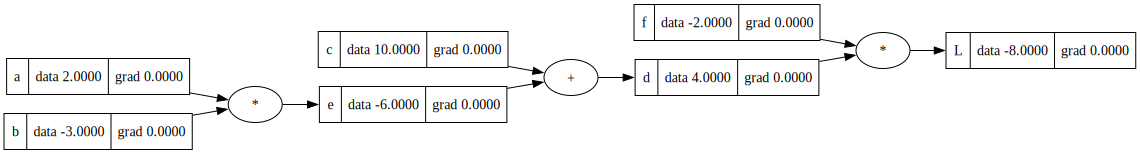

In [204]:
draw_dot(L)

In [205]:
def lol():
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 , label = 'f')
    L = d*f ; L.label = 'L'

    L1 = L.data

    a = Value(2.0 +h, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 , label = 'f')
    L = d*f ; L.label = 'L'

    L2 = L.data

    print((L2-L1)/h)


lol()

6.000000000000227


In [206]:
import torch
import random

In [207]:
# match micrograd with Pytorch API:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True;
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True;
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True;
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True;
b = torch.Tensor([6.8813735870196]).double(); b.requires_grad = True;
n = x1 *w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('_____')
print('x1 ', x1.grad.item())
print('w1 ', w1.grad.item())
print('x2 ', x2.grad.item())
print('w2 ', w2.grad.item())

0.7071066904050358
_____
x1  -1.5000003851533106
w1  1.0000002567688737
x2  0.5000001283844369
w2  0.0


In [216]:
# another class of mathematical expressions:

class Neuron:

    def __init__(self, nin): #nin = number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight 
        self.b = Value( random.uniform(-1,1))  #bias

    def __call__(self, x):
        """
        writes classes where the instances behave like functions 
        and can be called like a function. When this method is defined, 
        calling an object (obj(arg1, arg2)) automatically triggers 
        obj.__call__(arg1, arg2). 
        """
        # returns w * x + b
        #activation = sum(wi*xi for wi, xi, in zip(self.w, x)) + self.b 
        # because sum can a second argument, the start, we can integrate self.b as start:
        activation = sum((wi*xi for wi, xi, in zip(self.w, x)), self.b ) #generator expression: Iterate once, save memory
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self,nin , nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] #list comprehension: Store, reuse, access items

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # returns the single value of the last neuron, the output

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


# define a MLP (multilayer perceptron)

class NLP:

    def __init__(self, nin, nouts): # list of nouts
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        
x = [2.0, 3.0]
#n = Neuron(2)
#n = Layer(2,3)
n = NLP(3, [4,4,1]) #3 inputs, 2 hidden layers with 4 neurons each, 1 output
print(n(x))

Value(data = 0.29087910340084466)


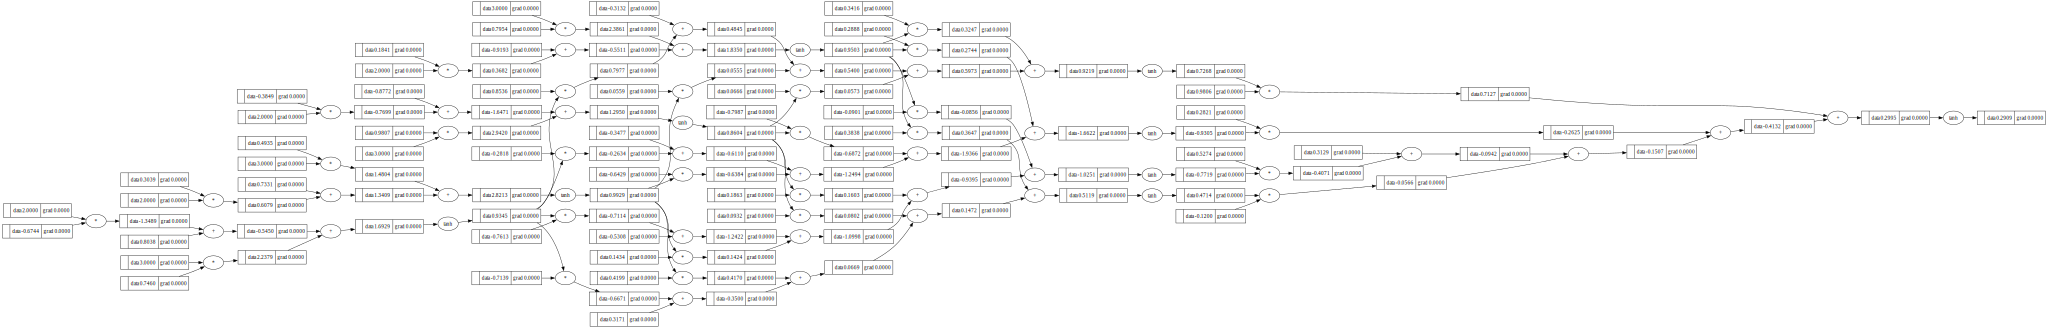

In [217]:
draw_dot(n(x))

In [218]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0 , 1.0] #desired targets

In [223]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update ( gradient descent)
    for p in n.parameters():
        p.data += 0.05 * p.grad

    print (k, loss.data)

0 3.2568333254377575
1 3.2568333254377575
2 3.2568333254377575
3 3.2568333254377575
4 3.2568333254377575
5 3.2568333254377575
6 3.2568333254377575
7 3.2568333254377575
8 3.2568333254377575
9 3.2568333254377575
10 3.2568333254377575
11 3.2568333254377575
12 3.2568333254377575
13 3.2568333254377575
14 3.2568333254377575
15 3.2568333254377575
16 3.2568333254377575
17 3.2568333254377575
18 3.2568333254377575
19 3.2568333254377575


In [224]:
ypred

[Value(data = 0.22034142901988332),
 Value(data = -0.5148716341634864),
 Value(data = -0.011378975480659958),
 Value(data = -0.1984343021935428)]